In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from skimage.exposure import rescale_intensity
import numpy as np
import argparse
import imutils
from collections import defaultdict
from copy import copy, deepcopy

import pandas as pd
import tensorflow as tf
import keras
np.random.seed(2)

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D , Activation
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


# Reading image and applying required transformations:

In [2]:
image = cv2.imread('car11.jpeg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
dim = (700,500)
width = 700
height = 500
image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
print(image.shape)
img = cv2.GaussianBlur(image,(3,3),0)

(500, 700)


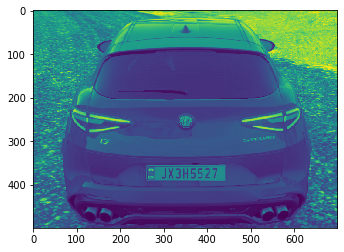

In [3]:
plt.imshow(image)
plt.show()

# Computing Vertical projection of the image:

In [4]:
sobelY = np.array((
	[-1, 0, 1],
	[-2, 0, 2],
	[-1, 0, 1]), dtype="int")
sobelX = np.array((
	[-1, -2, -1],
	[0, 0, 0],
	[1, 2, 1]), dtype="int")
hor_filter = cv2.filter2D(image, -1, sobelX)
ver_filter = cv2.filter2D(image, -1, sobelY)

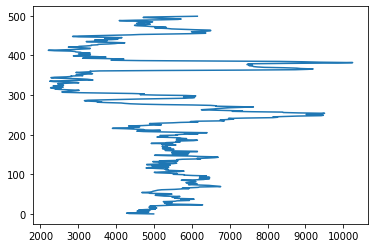

In [5]:
ver_projection = np.sum(ver_filter,1)
plt.plot(ver_projection,np.arange(0,height,1))

In [6]:
# Rank matrix used for smoothening of the vertical projection.
rank_matrix = []
for i in range(0,9):
    rank_matrix.append(1/9)

# Band clipping followed by Plate clipping to obtain potential Number Plates:

In [7]:
smooth_ver_proj = np.convolve(ver_projection, rank_matrix)
smooth_ver_proj = smooth_ver_proj[:500]
smooth_ver_proj_copy = []
for x in smooth_ver_proj:
    smooth_ver_proj_copy.append(x)
c1 = 0.55
c2 = 0.42
ybm = np.amax(smooth_ver_proj)
ybm_index = np.where(smooth_ver_proj == np.amax(smooth_ver_proj))[0][0]
bands = []
while(ybm > 0):
    yb0 = 0
    yb1 = 600
    for i in range(0,ybm_index):
        if(i > yb0 and c1*smooth_ver_proj[ybm_index] >= smooth_ver_proj[i]):
            yb0 = i
    for i in range(ybm_index,500):
        if(i < yb1 and c1*smooth_ver_proj[ybm_index] >= smooth_ver_proj[i]):
            yb1 = i
            break
    for i in range(yb0,min(yb1+1,500)):
        smooth_ver_proj[i] = 0
    bands.append([yb0,ybm_index,min(yb1+1,500)])
    ybm = np.amax(smooth_ver_proj)
    ybm_index = np.where(smooth_ver_proj == np.amax(smooth_ver_proj))[0][0]
print(bands)

[[230, 255, 283], [364, 385, 394], [5, 96, 231], [430, 464, 500], [282, 299, 313], [393, 394, 431], [312, 363, 365], [1, 4, 6], [0, 0, 2]]


In [8]:
Horizontal_Projections_of_bands = []
for band in bands:
    yb0 = band[0]
    yb1 = band[2]
    Band_proj = []
    for i in range(0,width):
        itr = 0
        for j in range(yb0,min(yb1+1,500)):
            itr += hor_filter[j][i]
        Band_proj.append(itr)
    Horizontal_Projections_of_bands.append(Band_proj)

In [9]:
cx = 0.86
Number_plate_candidates = []
for Band_proj in Horizontal_Projections_of_bands:
    smooth_hor_band_proj = np.convolve(Band_proj, rank_matrix)
    smooth_hor_band_proj = smooth_hor_band_proj[:700]
    xbm = np.amax(smooth_hor_band_proj)
    xbm_index = np.where(smooth_hor_band_proj == np.amax(smooth_hor_band_proj))[0][0]
    Plates = []
    xb0 = 0
    xb1 = 800
    for i in reversed(range(0,xbm_index)):
        if(i > xb0 and cx*smooth_hor_band_proj[xbm_index] >= smooth_hor_band_proj[i]):
            xb0 = i
            break
    for i in range(xbm_index,700):
        if(i < xb1 and cx*smooth_hor_band_proj[xbm_index] >= smooth_hor_band_proj[i]):
            xb1 = i
            break
    Number_plate_candidates.append([xb0,xbm_index,min(xb1+1,700)])

In [10]:
rank_matrix1 = []
for i in range(0,20):
    rank_matrix1.append(1/20)

In [11]:
Horizontal_Projections_of_plates = []
ind = 0
for band_proj in Horizontal_Projections_of_bands:
    Horizontal_Projections_of_plates.append(band_proj[Number_plate_candidates[ind][0]:Number_plate_candidates[ind][2]])
    ind+=1

In [12]:
hor_projection = np.sum(hor_filter,0)
smooth_hor_proj_on_hf = np.convolve(hor_projection,rank_matrix1)

In [13]:
hor_proj_derivative = []
for i in range(0,699):
    hor_proj_derivative.append(int(smooth_hor_proj_on_hf[i+1])-int(smooth_hor_proj_on_hf[i]))
hor_proj_derivative.append(0)

In [14]:
cd = 0.42
xp0 = 0
xp1 = 1000
xp_min = np.amin(hor_proj_derivative[int(width/4):int(width/2)])
xp_max = np.amax(hor_proj_derivative[int(width/2):int(3*width/4)])
for i in range(int(width/4),int(width/2)):
    if(hor_proj_derivative[i] >= cd*xp_max):
        xp0 = i
        break
for i in reversed(range(int(width/2),int(3*width/4))):
    if(hor_proj_derivative[i] <= cd*xp_min):
        xp1 = i
        break

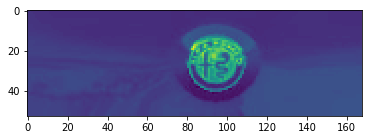

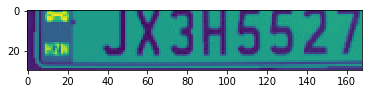

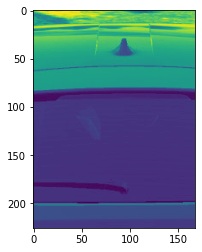

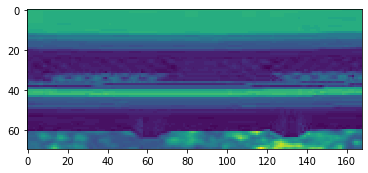

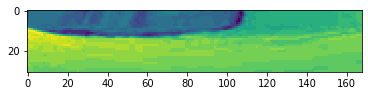

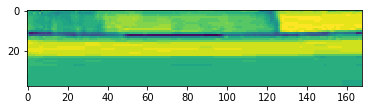

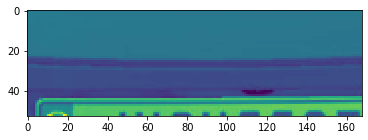

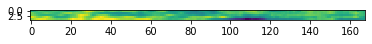

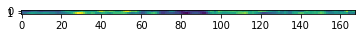

In [15]:
candidate_plates = []
for i in bands:
    candidate_plates.append(image[i[0]:i[2],xp0:xp1])
    plt.imshow(image[i[0]:i[2],xp0:xp1])
    plt.show()

In [18]:
adaptive_threshold = []
for i in candidate_plates:
    temp = cv2.adaptiveThreshold(i,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
    adaptive_threshold.append(temp)

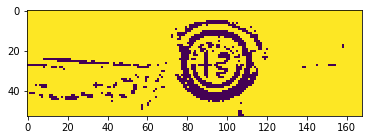

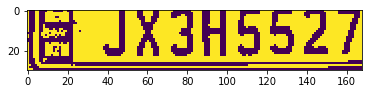

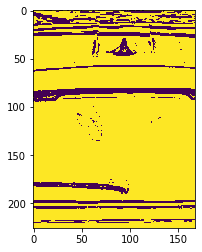

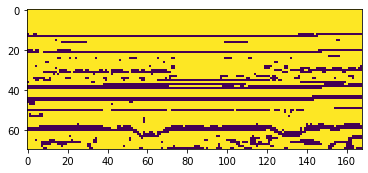

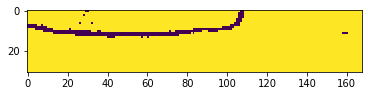

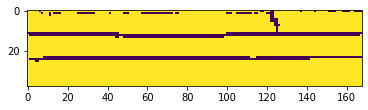

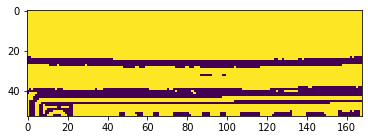

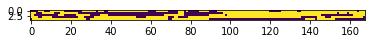

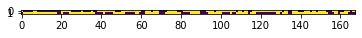

In [19]:
for i in adaptive_threshold:
    plt.imshow(i)
    plt.show()

In [20]:
ver_proj_of_candidate_plates = []
for i in adaptive_threshold:
    ver_proj_of_candidate_plates.append(np.sum(i,0))

In [21]:
# plt.plot(np.arange(0,ver_proj_of_candidate_plates[0].shape[0],1),ver_proj_of_candidate_plates[0])

# Defining some utility functions:

In [22]:
def floodfill(component):
    S = set()
    for i in range(len(component)):
        for j in range(len(component[0])):
            if(component[i][j]==0):S.add((i,j))
    Pieces = []
    while(len(S)!=0):
        C = S.pop()
        P = set()
        A = set()
        A.add(C)
        while(len(A)!=0):
            C = A.pop()
            x = C[0]
            y = C[1]
            if (x+1,y) not in P:
                if (x+1,y) in S:
                    A.add((x+1,y))
                    S.remove((x+1,y))
            if (x-1,y) not in P:
                if (x-1,y) in S:
                    A.add((x-1,y))
                    S.remove((x-1,y))
            if (x,y+1) not in P:
                if (x,y+1) in S:
                    A.add((x,y+1))
                    S.remove((x,y+1))
            if (x,y-1) not in P:
                if (x,y-1) in S:
                    A.add((x,y-1))
                    S.remove((x,y-1))
            P.add(C)
        Pieces.append(list(P))
    Component_list = []
    for P in Pieces:
        temp_component = []
        x_min=1000
        x_max=-1
        y_min=1000
        y_max=-1
        for i in P:
            x_min=min(x_min,i[0])
            x_max=max(x_max,i[0])
            y_min=min(y_min,i[1])
            y_max=max(y_max,i[1])
            
        for i in range(len(component)):
            temp = []
            for j in range(len(component[0])):
                temp.append(255)
            temp_component.append(temp)
        for l in P:
            temp_component[l[0]][l[1]] = 0
        Component_list.append(np.array(temp_component)[x_min:x_max+1,y_min:y_max+1].tolist())
    return Component_list

In [23]:
def rgb_to_hsv(r, g, b):
    r, g, b = r / 255.0, g / 255.0, b / 255.0
    cmax = max(r, g, b)    # maximum of r, g, b 
    cmin = min(r, g, b)    # minimum of r, g, b 
    diff = cmax-cmin       # diff of cmax and cmin. 
    if cmax == cmin:  
        h = 0
    elif cmax == r:  
        h = (60 * ((g - b) / diff) + 360) % 360
    elif cmax == g: 
        h = (60 * ((b - r) / diff) + 120) % 360
    elif cmax == b: 
        h = (60 * ((r - g) / diff) + 240) % 360
    if cmax == 0: 
        s = 0
    else: 
        s = (diff / cmax) * 100
    v = cmax * 100
    return h, s, v 

In [24]:
def heuristics(extraction):
    pb=0
    h=len(extraction)
    w=len(extraction[0])
    for i in range(0,len(extraction)):
        for j in range(0,len(extraction[i])):
            pb=pb+extraction[i][j]
    pc=0;
    for i in range(0,len(extraction)):
        for j in range(0,len(extraction[i])):
            pc=pc+(pb-extraction[i][j])*(pb-extraction[i][j])
    pc=pc/(h*w)
    pc=np.sqrt(pc)
    H=[]
    S=[]
    ph=0
    ps=0
    for i in range(0,h):
        temp=[]
        for j in range(0,w):
            temp.append(0)
        H.append(temp)
        S.append(temp)
    for i in range(0,h):
        for j in range(0,w):
            hh,ss,vv= rgb_to_hsv(extraction[i][j],extraction[i][j],extraction[i][j])
            H[i][j]=hh
            S[i][j]=ss
    for i in range(0,h):
        for j in range(0,w):
            ph=ph+H[i][j]
            ps=ps+S[i][j]
    ans=[]
    ans.append(pb)
    ans.append(pc)
    ans.append(ph)
    ans.append(ps)
    ans.append(h)
    ans.append(w)
    return ans

In [25]:
def display_segments(segments):
    for segment in segments:
        plt.imshow(np.asarray(segment),cmap="gray")
        plt.show()

In [26]:
def BRI(pb,pb_avg):
    x=1.0*(pb-pb_avg)/pb_avg
    if(abs(x)< 0.16):
        return True
    else :
        return False
def CON(pc,pc_avg):
    x=1.0*(pc-pc_avg)/pc_avg
    if(abs(x)< 0.1):
        return True
    else :
        return False
def HUE(ph,ph_avg):
    x=1.0*(ph-ph_avg)/ph_avg
    if(abs(x)< 0.145):
        return True
    else :
        return False
def SAT(ps,ps_avg):
    x=1.0*(ps-ps_avg)/ps_avg
    if(abs(x)< 0.24):
        return True
    else :
        return False
def HEI(h,h_avg):
    x=1.0*(h-h_avg)/h_avg
    if(abs(x)< 0.2):
        return True
    else :
        return False
def WHR(w,h):
    x=1.0*w/h
    if(x< 0.92 and x>0.1):
        return True
    else :
        return False
def pre_heuristics(segment):
    nb=0
    h=len(segment)
    w=len(segment[0])
    for i in range(h):
        for j in range(w):
            if(segment[i][j]==0):
                nb=nb+1
    nw=(w*h)-nb
    return nw

In [27]:
def eight_pixel_neighbourhood(pixel):
    array = []
    array.append([pixel[0]-1,pixel[1]-1])
    array.append([pixel[0]-1,pixel[1]])
    array.append([pixel[0]-1,pixel[1]+1])
    array.append([pixel[0],pixel[1]+1])
    array.append([pixel[0]+1,pixel[1]+1])
    array.append([pixel[0]+1,pixel[1]])
    array.append([pixel[0]+1,pixel[1]-1])
    array.append([pixel[0],pixel[1]-1])
    return array

In [28]:
def get_boundary_pixels(image):
    boundary_pixels=[]
    h,w = np.asarray(image).shape
    for i in range(1,h):
        for j in range(1,w):
            if(image[i][j] == 0):
                epn = eight_pixel_neighbourhood([i,j])
                for p in epn:
                    if(image[p[0]][p[1]] == 255):
                        boundary_pixels.append([i,j])
                        break
    return boundary_pixels

In [29]:
def flagging_and_deleting(image):
    new_image = deepcopy(image)
    boundary_pixels = get_boundary_pixels(new_image)
    flagged=[]
    for p in boundary_pixels:
        if(image[p[0]-1][p[1]] == 0 and image[p[0]][p[1]+1] == 0 and image[p[0]+1][p[1]] == 0):
            continue
        if(image[p[0]][p[1]-1] == 0 and image[p[0]][p[1]+1] == 0 and image[p[0]+1][p[1]] == 0):
            continue
        neighbourhood = eight_pixel_neighbourhood(p)
        black_neighbour_pixels = 0
        for neighbour in neighbourhood:
            if(image[neighbour[0]][neighbour[1]] == 0): black_neighbour_pixels += 1
        if(black_neighbour_pixels < 2 or black_neighbour_pixels > 6):
            continue
        wtb_transitions = 0
        for i in range(len(neighbourhood)):
            if(image[neighbourhood[i][0]][neighbourhood[i][1]] == 255 and
                  image[neighbourhood[(i+1)%8][0]][neighbourhood[(i+1)%8][1]] == 0):
                wtb_transitions += 1
        if(wtb_transitions != 1):
            continue
        flagged.append(p)
    if(len(flagged) == 0):
        return new_image,-1
    elif(len(flagged) != 0):
        for f in flagged:
            new_image[f[0]][f[1]] = 255
        return new_image,0

In [30]:
def skeletonize(image):
    skeletonized_image,temp = flagging_and_deleting(image)
    while(1):
        temp_image,status = flagging_and_deleting(skeletonized_image)
        if(status == 0):
            skeletonized_image = deepcopy(temp_image)
        elif(status == -1):
            break
    return skeletonized_image

In [31]:
def Alphabet(num):
    AlphaDict = {0:'A',1:'B',2:'C',3:'D',4:'E',5:'F',6:'G',7:'H',8:'I',9:'J',10:'K',11:'L',12:'M',13:'N',14:'O',15:'P',16:'Q',17:'R',18:'S',19:'T',20:'U',21:'V',22:'W',23:'X',24:'Y',25:'Z'}
    return AlphaDict[num]

# Extracting Characters from obtained candidate plates:

In [32]:
# Run cell above containing 'ver_proj_of_candidate_plates' before re-running this cell
extraction=[]
count = 0
for i in ver_proj_of_candidate_plates:
    vm = max(i)
    va = (sum(i)*1.0)/len(i)
    vb = (2*va)-vm
    cx = 0.7
    cw = 0.86
    xm = np.where(i == np.amax(i))[0][0]
    boundaries = []
    while(i[xm]>=cw*vm):
        xl=xm-1
        xr=xm+1
        for j in range(0,xm):
            if(i[j] >= cx*i[xm]):
                xl = j
        for j in range(xm,len(i)):
            if(i[j] <= cx*i[xm]):
                xr = j
                break
        for j in range(max(xl,0),min(xr+1,len(i))):
            i[j] = 0
        boundaries.append(xm)
        xm = np.where(i == np.amax(i))[0][0]
    boundaries.append(len(i))
    boundaries.sort()
    k = boundaries[0]
    for j in range(1,len(boundaries)):
        extraction.append(np.array(adaptive_threshold[count])[:,k:boundaries[j]].tolist())
        k = boundaries[j]
    count += 1

In [33]:
segments=[]
for ele in extraction:
    ele1 = floodfill(ele)
    for j in ele1:
        segments.append(j)

In [34]:
phase1=[]
for segment in segments:
    nw=pre_heuristics(segment)
    h=np.asarray(segment).shape[0]
    w=np.asarray(segment).shape[1]
    r=1.0*h/w
    if(nw>(h*w)/5 and nw < (h*w)*(4/5) and h > 5 and w > 4 and (r>=1.5 and r<=3.0)):
        phase1.append(segment)

In [111]:
phase2 = []
for image in phase1:
    temp_image=[]
    h,w = np.asarray(image).shape
    for i in range(h+1):
        temp_row = []
        for j in range(w+1):
            temp_row.append(255)
        temp_image.append(temp_row)
    for i in range(1,h):
        for j in range(1,w):
            temp_image[i][j] = image[i-1][j-1]
    phase2.append(temp_image)
i = 0
while(i < len(phase2)):
  phase2[i] = np.asarray(phase2[i])
  i += 1

In [125]:
mnist_model = tf.keras.models.load_model("numeric_model.h5")
alpha_model = tf.keras.models.load_model("alpha_model.h5")
alphaumeric_model = tf.keras.models.load_model("alphanumeric_model.h5")

In [126]:
numbers_test=[]
alpha_test=[]
alpha_numeric_test = []
i = 0
while(i < len(phase2)):
  temp1 = cv2.resize(phase2[i].astype('float32') / 255.0, (32,32), interpolation = cv2.INTER_AREA).reshape(32,32,1)
  temp2 = cv2.resize(phase2[i].astype('float32') / 255.0, (32,32), interpolation = cv2.INTER_AREA).reshape(32,32,1)
  numbers_test.append(temp1)
  alpha_test.append(temp2)
  alpha_numeric_test.append(temp2)
  i += 1
numbers_test = np.asarray(numbers_test)
alpha_test = np.asarray(alpha_test)
alpha_numeric_test = np.asarray(alpha_numeric_test)

In [127]:
numbers = mnist_model.predict(numbers_test)
alpha = alpha_model.predict(alpha_test)
alphanumeric = alphaumeric_model.predict(alpha_numeric_test)

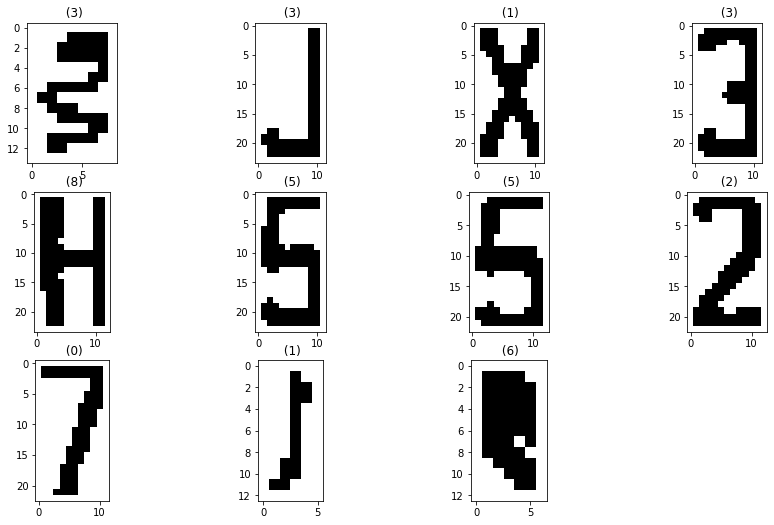

In [130]:
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 5
for i in range(1, len(phase2)):
    img = np.asarray(phase2[i])
    fig.add_subplot(rows, columns, i).set_title(' ('+str(np.argmax(alphanumeric[i]))+')')
    plt.imshow(img,cmap='gray')
plt.show()

# Recognition on Number Plates:

In [101]:
image = cv2.imread('Plates/4.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = cv2.GaussianBlur(image,(3,3),0)
image3 = cv2.imread('Plates/10.png')
image3 = cv2.cvtColor(image3, cv2.COLOR_BGR2GRAY)
image3 = cv2.GaussianBlur(image3,(3,3),0)
image4 = cv2.imread('Plates/12.png')
image4 = cv2.cvtColor(image4, cv2.COLOR_BGR2GRAY)
image4 = cv2.GaussianBlur(image4,(3,3),0)
candidate_plates = []
candidate_plates.append(np.asarray(image))
candidate_plates.append(np.asarray(image4))
candidate_plates.append(np.asarray(image3))

In [102]:
adaptive_threshold_plates = []
for i in candidate_plates:
    temp = cv2.adaptiveThreshold(i,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
    adaptive_threshold_plates.append(temp)
ver_proj_of_plates = []
for i in adaptive_threshold_plates:
    ver_proj_of_plates.append(np.sum(i,0))

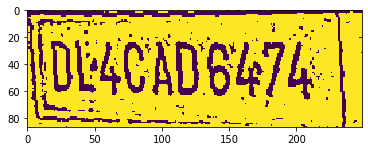

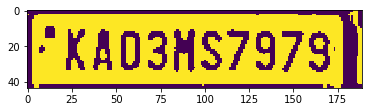

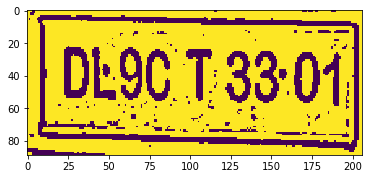

In [103]:
for i in adaptive_threshold_plates:
    plt.imshow(i)
    plt.show()

In [104]:
extraction_plates=[]
count = 0
for i in ver_proj_of_plates:
    vm = max(i)
    va = (sum(i)*1.0)/len(i)
    vb = (2*va)-vm
    cx = 0.7
    cw = 0.86
    xm = np.where(i == np.amax(i))[0][0]
    boundaries = []
    while(i[xm]>=cw*vm):
        xl=xm-1
        xr=xm+1
        for j in range(0,xm):
            if(i[j] >= cx*i[xm]):
                xl = j
        for j in range(xm,len(i)):
            if(i[j] <= cx*i[xm]):
                xr = j
                break
        for j in range(max(xl,0),min(xr+1,len(i))):
            i[j] = 0
        boundaries.append(xm)
        xm = np.where(i == np.amax(i))[0][0]
    boundaries.append(len(i))
    boundaries.sort()
    k = boundaries[0]
    for j in range(1,len(boundaries)):
        extraction_plates.append(np.array(adaptive_threshold_plates[count])[:,k:boundaries[j]].tolist())
        k = boundaries[j]
    count += 1

In [105]:
segments_plate=[]
for ele in extraction_plates:
    ele1 = floodfill(ele)
    for j in ele1:
        segments_plate.append(j)

In [106]:
phase1_plate=[]
for segment in segments_plate:
    nw=pre_heuristics(segment)
    h=np.asarray(segment).shape[0]
    w=np.asarray(segment).shape[1]
    r=1.0*h/w
    if(nw>(h*w)/5 and nw < (h*w)*(4/5) and h > 10 and w > 4 and (r>=1.5 and r<=3.0)):
        phase1_plate.append(segment)
phase2_plate = []
for image in phase1_plate:
    temp_image=[]
    h,w = np.asarray(image).shape
    for i in range(h+1):
        temp_row = []
        for j in range(w+1):
            temp_row.append(255)
        temp_image.append(temp_row)
    for i in range(1,h):
        for j in range(1,w):
            temp_image[i][j] = image[i-1][j-1]
    phase2_plate.append(temp_image)

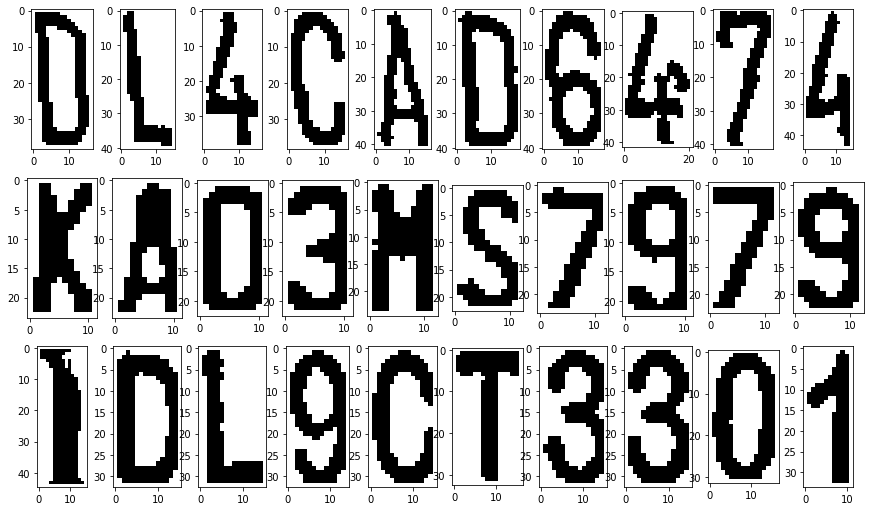

In [107]:
fig=plt.figure(figsize=(15, 15))
columns = 10
rows = 5
for i in range(1, len(phase2_plate)):
    img = np.asarray(phase2_plate[i])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img,cmap='gray')
plt.show()